Epoch 1/60


/tmp/ipython-input-1599723902.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = pd.read_csv("/content/japan_covid_master_data.csv").fillna(method='ffill')
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0011 - val_loss: 0.0321 - learning_rate: 0.0010
Epoch 2/60
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 9.9344e-04 - val_loss: 0.0303 - learning_rate: 0.0010
Epoch 3/60
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 9.8332e-04 - val_loss: 0.0294 - learning_rate: 0.0010
Epoch 4/60
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 9.7682e-04 - val_loss: 0.0288 - learning_rate: 0.0010
Epoch 5/60
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 9.4662e-04 - val_loss: 0.0279 - learning_rate: 0.0010
Epoch 6/60
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 9.1074e-04 - val_loss: 0.0270 - learning_rate: 0.0010
Epoch 7/60
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 8.8073e-04 - val_loss: 0.0261 - learning_rate: 0.0010
Epoch 8/60
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 8.6315e-04 - val_loss: 0.0251 - learning_rate: 0.0010
Epoch 9/60
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 8.3489e-04 - val_loss: 0.0237 - learning_rate: 0.001

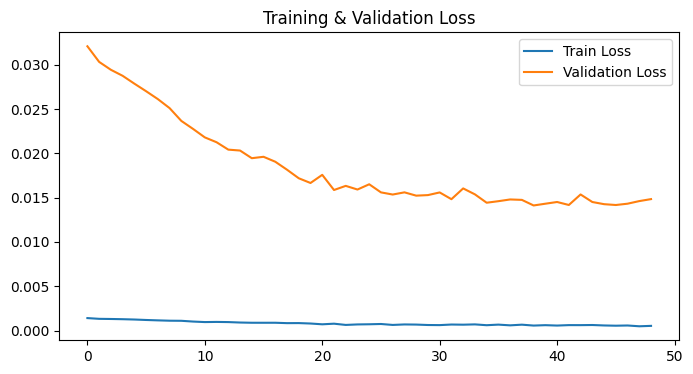

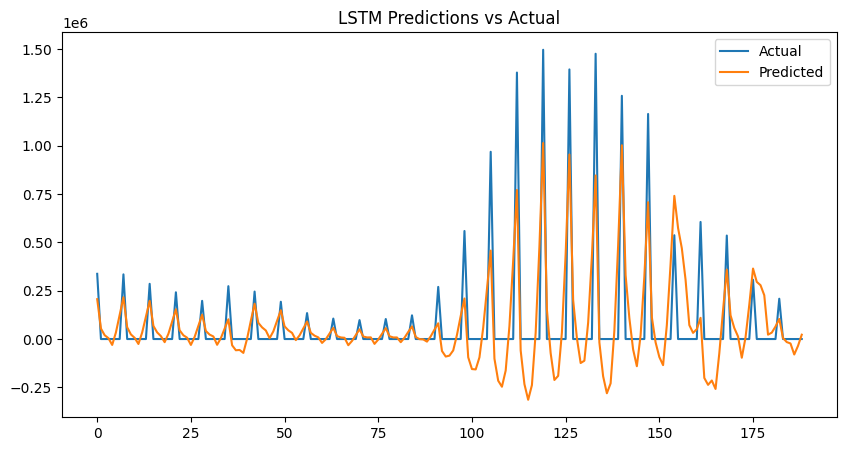

In [29]:
# --- Final Refined LSTM Model for Disease Outbreak Prediction ---

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, json, math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# === 1. Setup ===
os.makedirs("/content/results", exist_ok=True)

# === 2. Load and prepare data ===
df = pd.read_csv("/content/japan_covid_master_data.csv").fillna(method='ffill')
data = df['new_cases'].values.reshape(-1, 1)

scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# === 3. Create sequences ===
def create_sequences(data, window=31):
    X, y = [], []
    for i in range(window, len(data)):
        X.append(data[i-window:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

window = 31  # balanced window size
X, y = create_sequences(data_scaled, window)
X = X.reshape((X.shape[0], X.shape[1], 1))

# === 4. Train-test split ===
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# === 5. Build LSTM model ===
model = Sequential([
    LSTM(64, input_shape=(window, 1)),
    Dropout(0.2),
    Dense(1)
])
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse')

# === 6. Callbacks ===
checkpoint_path = "/content/results/lstm_best_model_final.keras"
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)
]

# === 7. Train ===
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=60,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

# === 8. Evaluate ===
y_pred = model.predict(X_test)
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1,1))

mae = mean_absolute_error(y_test_inv, y_pred_inv)
rmse = math.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
r2 = r2_score(y_test_inv, y_pred_inv)

metrics = {"MAE": mae, "RMSE": rmse, "R2": r2}
with open("/content/results/lstm_metrics_final.json", "w") as f:
    json.dump(metrics, f, indent=4)

print("Metrics:", metrics)

# === 9. Plot training history ===
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Training & Validation Loss")
plt.legend()
plt.savefig("/content/results/lstm_train_final.png")
plt.show()

# === 10. Plot predictions ===
plt.figure(figsize=(10,5))
plt.plot(y_test_inv, label='Actual')
plt.plot(y_pred_inv, label='Predicted')
plt.title("LSTM Predictions vs Actual")
plt.legend()
plt.savefig("/content/results/lstm_preds_final.png")
plt.show()
